In [2]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
from azureml.core import Workspace, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import StringIO


In [5]:
ws = Workspace.from_config()

# Load the datastore where your blob is mounted
datastore = ws.datastores['alzheimersdata']  

# Load dataset from the file in blob container
dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'combined_dataset.csv'))
df = dataset.to_pandas_dataframe()
df.head()


Timeout was exceeded in force_flush().
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.8,seurat_clusters,marker_cell_type,scina_cell_type,predicted.id,source_file,group,...,library_preparation_protocol,library_preparation_protocol__ontology_label,orig_index,batch,time,replicate,label,region_merged,top_level_cell_type,sub_level_cell_type
0,healthy,11224.0,5016.0,3.0,3,Excitatory neurons,Excitatory neurons,Excitatory neurons,AD00101.qsave,None,...,None,None,None,None,None,None,None,None,None,None
1,healthy,1506.0,1020.0,4.0,4,Oligodendrocytes,Oligodendrocytes,Oligodendrocytes,AD00101.qsave,None,...,None,None,None,None,None,None,None,None,None,None
2,healthy,1686.0,1111.0,5.0,5,Astrocytes,Microglia,Excitatory neurons,AD00101.qsave,None,...,None,None,None,None,None,None,None,None,None,None
3,healthy,913.0,674.0,5.0,5,Astrocytes,Oligodendrocytes,Excitatory neurons,AD00101.qsave,None,...,None,None,None,None,None,None,None,None,None,None
4,healthy,1230.0,889.0,4.0,4,Oligodendrocytes,Oligodendrocytes,Oligodendrocytes,AD00101.qsave,None,...,None,None,None,None,None,None,None,None,None,None


In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
nCount_RNA,4394011.0,4510.191947,20386.493964,0.0,938.034975,1957.0,4360.0,1.661989e+06
nFeature_RNA,4394011.0,1583.157589,1348.897986,0.0,554.000000,1112.0,2308.0,1.521000e+04
RNA_snn_res.0.8,1231541.0,6.841422,6.587833,0.0,1.000000,5.0,10.0,3.200000e+01
seurat_clusters,10420647.0,7.765024,12.841237,0.0,0.000000,2.0,10.0,1.700000e+02


In [ ]:
print("Shape:", df.shape)


Shape: (10420647, 202)
Data types:
 orig.ident              object
nCount_RNA             float64
nFeature_RNA           float64
RNA_snn_res.0.8        float64
seurat_clusters          int64
                        ...   
replicate               object
label                   object
region_merged           object
top_level_cell_type     object
sub_level_cell_type     object
Length: 202, dtype: object
Missing values:
 specify.other.race     10420647
Level_03               10419118
strain                 10417623
region_broad           10417623
developmental_stage    10417623
storage                10416067
Spatial_snn_res.0.8    10415866
Allen.Atlas.ID         10415101
Brain.frozen           10415101
Genotype.x             10415101
dtype: int64


In [5]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns


In [6]:
# Fill numeric columns with 0
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(0, inplace=True)

In [7]:
#Define relevant categorical columns for Alzheimer's project
relevant_categorical_cols = [
    'label',
    'region_merged',
    'top_level_cell_type',
    'sub_level_cell_type',
    'replicate',
    'orig.ident',
    'seurat_clusters',        
    'Genotype.x',             
    'developmental_stage'     
]

# Step 2: Drop other categorical columns not in the list
all_object_cols = df.select_dtypes(include='object').columns.tolist()
cols_to_drop = list(set(all_object_cols) - set(relevant_categorical_cols))
df.drop(columns=cols_to_drop, inplace=True)

# Step 3: Fill missing values only in the relevant ones (still present in DataFrame)
for col in relevant_categorical_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')

# Final check
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10420647 entries, 0 to 10420646
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   orig.ident           object 
 1   nCount_RNA           float64
 2   nFeature_RNA         float64
 3   RNA_snn_res.0.8      float64
 4   seurat_clusters      int64  
 5   Genotype.x           object 
 6   developmental_stage  object 
 7   replicate            object 
 8   label                object 
 9   region_merged        object 
 10  top_level_cell_type  object 
 11  sub_level_cell_type  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 954.0+ MB


In [8]:
print("Missing values:\n", df.isnull().sum().sort_values(ascending=False).head(10))

Missing values:
 orig.ident             0
nCount_RNA             0
nFeature_RNA           0
RNA_snn_res.0.8        0
seurat_clusters        0
Genotype.x             0
developmental_stage    0
replicate              0
label                  0
region_merged          0
dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10420647 entries, 0 to 10420646
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   orig.ident           object 
 1   nCount_RNA           float64
 2   nFeature_RNA         float64
 3   RNA_snn_res.0.8      float64
 4   seurat_clusters      int64  
 5   Genotype.x           object 
 6   developmental_stage  object 
 7   replicate            object 
 8   label                object 
 9   region_merged        object 
 10  top_level_cell_type  object 
 11  sub_level_cell_type  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 954.0+ MB


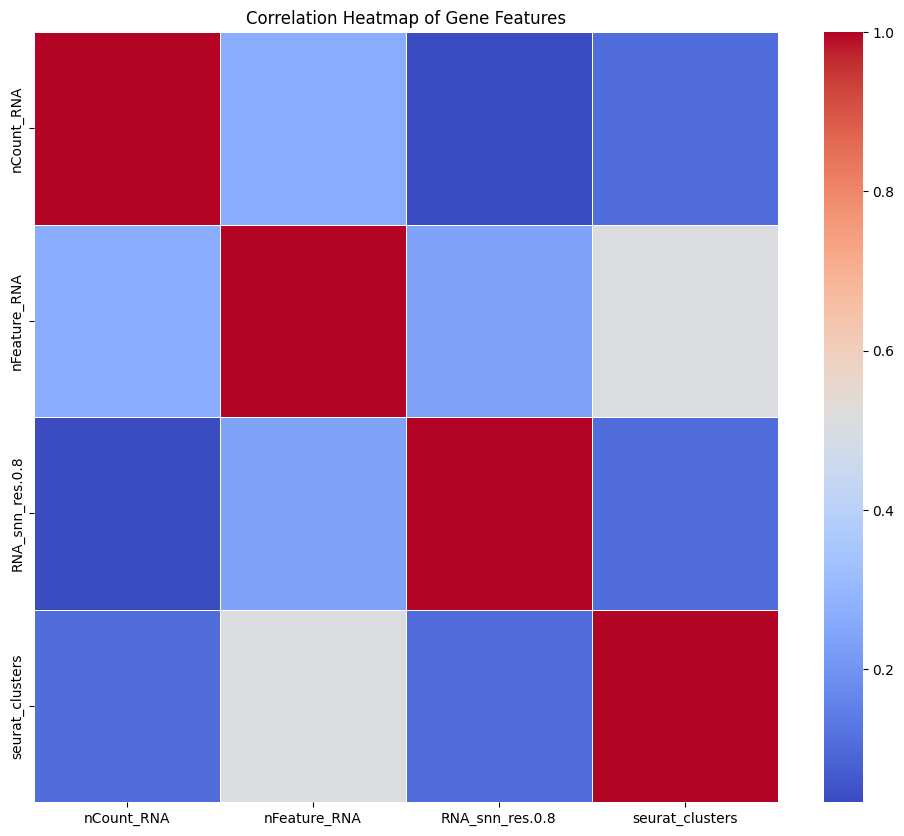

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Gene Features")
plt.show()


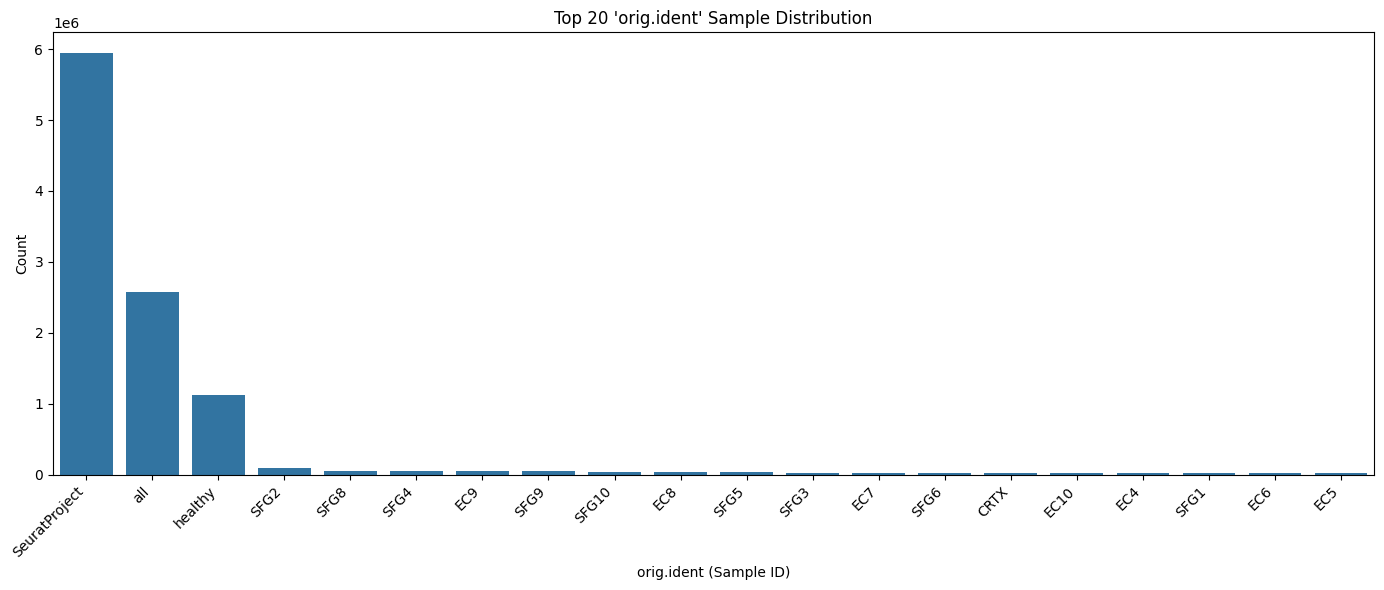

In [18]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='orig.ident', order=df['orig.ident'].value_counts().index[:20])  # Show top 20 only
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 'orig.ident' Sample Distribution")
plt.xlabel("orig.ident (Sample ID)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


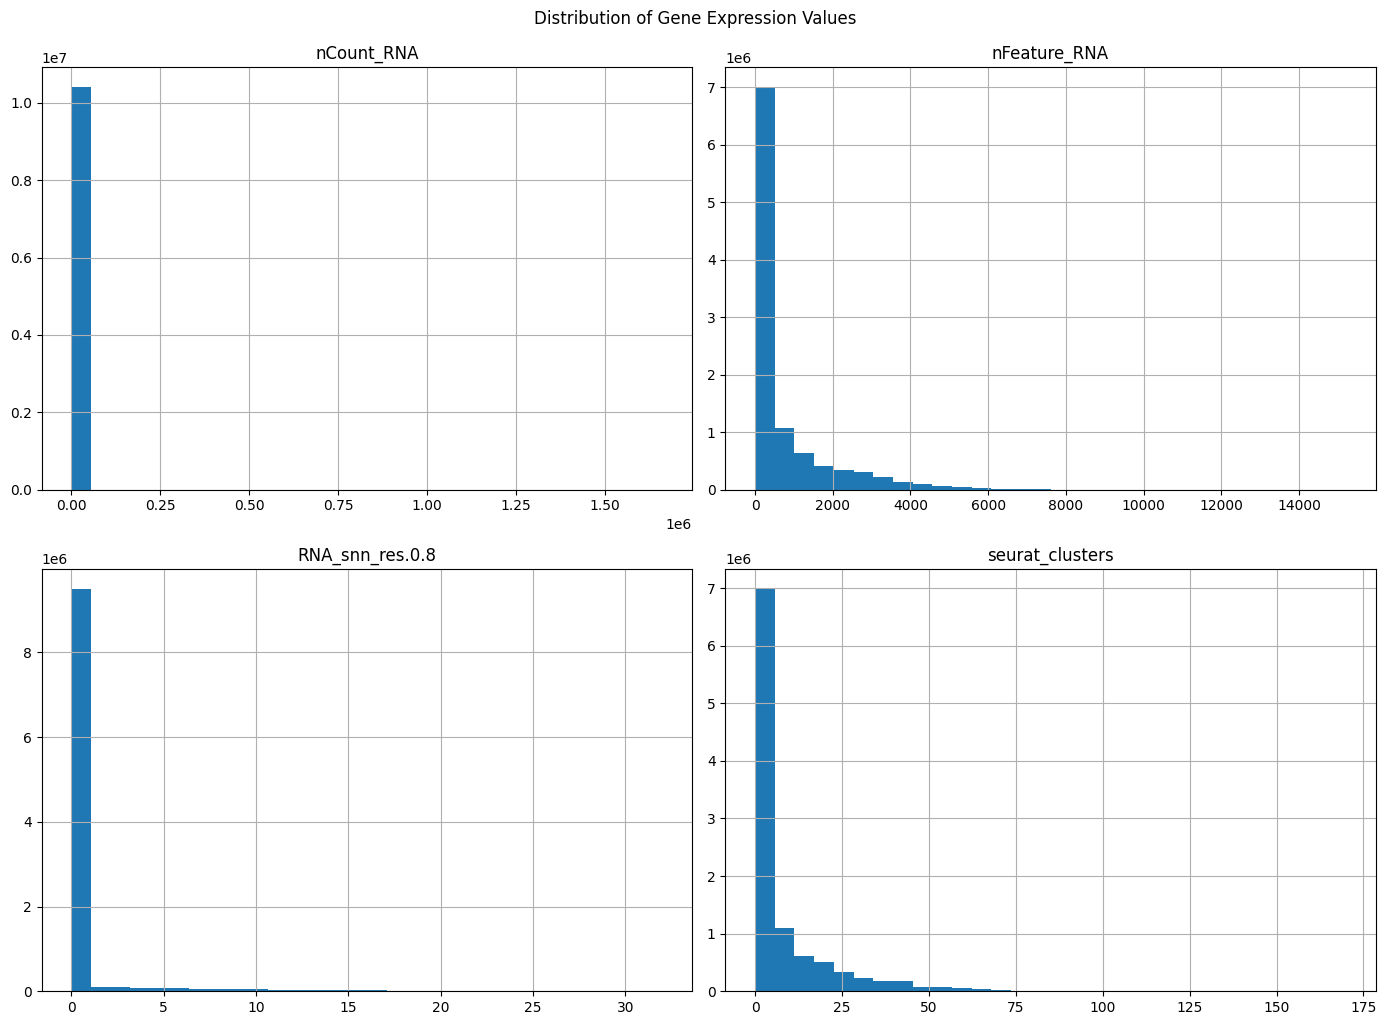

In [16]:
sample_cols = df.columns[1:11]  # visualize first 10 genes
df[sample_cols].hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.suptitle("Distribution of Gene Expression Values", y=1.02)
plt.show()


In [20]:

# Step 1: Select only numerical columns (float and int types)
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Optional: Filter out ID-like columns (if any) before computing correlation
# numeric_df = numeric_df.drop(columns=['some_id_col'])

# Step 2: Compute the correlation matrix
corr_matrix = numeric_df.corr()




In [21]:
print(corr_matrix)

                 nCount_RNA  nFeature_RNA  RNA_snn_res.0.8  seurat_clusters
nCount_RNA         1.000000      0.265420         0.033387         0.105873
nFeature_RNA       0.265420      1.000000         0.239970         0.509077
RNA_snn_res.0.8    0.033387      0.239970         1.000000         0.107881
seurat_clusters    0.105873      0.509077         0.107881         1.000000


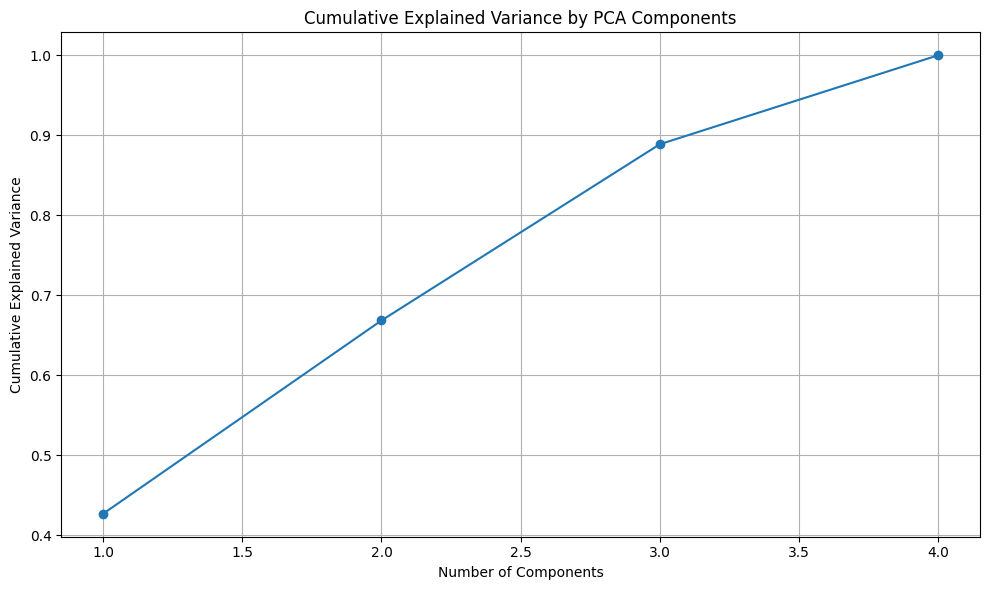

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Select only numeric features
numeric_df = df.select_dtypes(include=['float64', 'int64']).dropna(axis=1)

# Step 2: Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Step 3: Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
pca_components = pca.fit_transform(scaled_data)

# Step 4: Plot variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.tight_layout()
plt.show()


In [23]:
from sklearn.feature_selection import VarianceThreshold

# Step 1: Only numeric values
numeric_df = df.select_dtypes(include=['float64', 'int64']).dropna(axis=1)

# Step 2: Variance threshold filtering
selector = VarianceThreshold(threshold=0.01)  # adjust threshold if needed
filtered_data = selector.fit_transform(numeric_df)

# Get selected column names
selected_columns = numeric_df.columns[selector.get_support()]

print("Number of selected features:", len(selected_columns))
print("Selected features:\n", selected_columns[:10])  # Show first 10


Number of selected features: 4
Selected features:
 Index(['nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters'], dtype='object')


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Filter only selected columns from df
selected_cols = ['nCount_RNA', 'nFeature_RNA', 'region_merged', 'top_level_cell_type', 'label']
df_small = df[selected_cols].copy()

# Separate again
numerical_cols = ['nCount_RNA', 'nFeature_RNA']
categorical_cols = ['region_merged', 'top_level_cell_type']

# Preprocessing pipelines
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('var_thresh', VarianceThreshold(threshold=0.01)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

# Run preprocessor
X_final = preprocessor.fit_transform(df_small)

print("Final shape:", X_final.shape)


Final shape: (10420647, 20)


In [11]:
# Select numerical only
numerical_df = df[['nCount_RNA', 'nFeature_RNA']].copy()

# Pipeline for numerical
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))  # 2D for easy visualization
])

num_pca_result = num_pipeline.fit_transform(numerical_df)


In [9]:
# Combine data
df_small = df[numerical_cols + categorical_cols].copy()

# Preprocessing full pipeline
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

full_pipeline = Pipeline([
    ('preprocess', full_preprocessor),
    ('pca', PCA(n_components=2))
])

full_pca_result = full_pipeline.fit_transform(df_small)


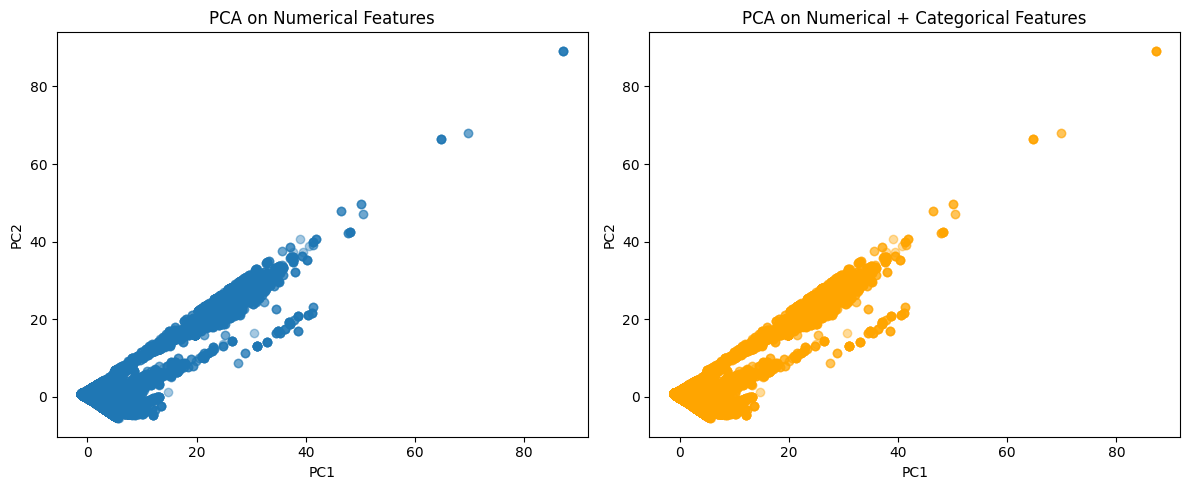

In [ ]:
# Plotting histograms for numeric columns
plt.figure(figsize=(12, 5))
# Numeric-only
plt.subplot(1, 2, 1)
plt.scatter(num_pca_result[:, 0], num_pca_result[:, 1], alpha=0.4)
plt.title("PCA on Numerical Features")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Full (numerical + categorical)
plt.subplot(1, 2, 2)
plt.scatter(full_pca_result[:, 0], full_pca_result[:, 1], alpha=0.4, color='orange')
plt.title("PCA on Numerical + Categorical Features")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


In [13]:
# Extract selected one-hot features
encoder = full_pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Full feature names after preprocessing (before PCA)
final_features = list(numerical_cols) + list(encoded_feature_names)
print("Final Features (Pre-PCA):")
print(final_features)


Final Features (Pre-PCA):
['nCount_RNA', 'nFeature_RNA', 'region_merged_Corpus Callosum', 'region_merged_Cortex', 'region_merged_Hippocampus', 'region_merged_None', 'top_level_cell_type_Astro', 'top_level_cell_type_CA1', 'top_level_cell_type_CA2', 'top_level_cell_type_CA3', 'top_level_cell_type_CTX-Ex', 'top_level_cell_type_DG', 'top_level_cell_type_Endo', 'top_level_cell_type_Inh', 'top_level_cell_type_LHb', 'top_level_cell_type_Micro', 'top_level_cell_type_OPC', 'top_level_cell_type_Oligo', 'top_level_cell_type_SMC', 'top_level_cell_type_None']


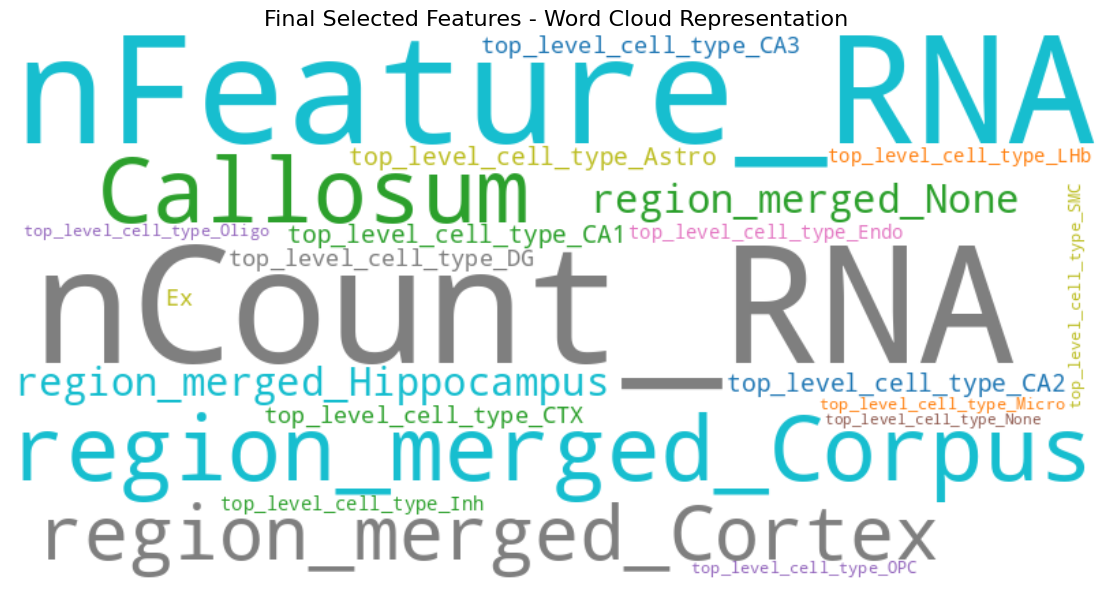

In [3]:
from wordcloud import WordCloud

# Final selected features
final_features = [
    'nCount_RNA', 'nFeature_RNA',
    'region_merged_Corpus Callosum', 'region_merged_Cortex', 'region_merged_Hippocampus', 'region_merged_None',
    'top_level_cell_type_Astro', 'top_level_cell_type_CA1', 'top_level_cell_type_CA2',
    'top_level_cell_type_CA3', 'top_level_cell_type_CTX-Ex', 'top_level_cell_type_DG',
    'top_level_cell_type_Endo', 'top_level_cell_type_Inh', 'top_level_cell_type_LHb',
    'top_level_cell_type_Micro', 'top_level_cell_type_OPC', 'top_level_cell_type_Oligo',
    'top_level_cell_type_SMC', 'top_level_cell_type_None'
]

# Convert to single string
text = ' '.join(final_features)

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Final Selected Features - Word Cloud Representation', fontsize=16)
plt.tight_layout()
plt.show()
